# compar_TotalVsModal_NRJ
Comparison of baroclinic energy: total vs. modal decomposition, bulk value (i.e. vertically integrated) and surface value.

Also compare barotropic -> baroclinic conversion term, simulation diag and linear theory (see part 2)

In [171]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
plt.rcParams["font.family"] = "serif"

import numpy as np
from netCDF4 import Dataset, MFDataset
import scipy.interpolate as itp
import sys, os, time
import pandas as pd
from PIL import Image, ImageDraw
import json
from collections import OrderedDict

In [75]:
simul = "luckym2"

whatfield = "HKE"
path_data = '/data0/project/vortex/lahaye/'
data_bcl = 'DIAG/NRJ_fluxes/{0}_bclnrj_M2.?.nc'.format(simul)
data_btr = 'DIAG/NRJ_fluxes/{0}_btrnrj.?.nc'.format(simul)
data_mod = '{0}_modemap/{0}_modemap.nc'.format(simul)
data_nrj = '{0}_modemap/{0}_modenrj.nc'.format(simul)

grid_file = path_data+"lucky_corgrd.nc"

## Plotting parameters
zlevs=[0,2000,3500]
topocol='k'     # isobath. contour color
grdcol='gray'   # grid color

dirpic = 'pictures/'
dosavefig = False


In [6]:
# load modal energy (vertical integral)
imod = slice(1,10)
rho0 = 1025.

nc = Dataset(path_data+data_nrj,'r')

times = nc.variables['time'][:]
nt = len(times)
modes = nc.variables['mode'][:]
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
lon = nc.variables['lon_rho'][:]
lat = nc.variables['lat_rho'][:]
if whatfield == "HKE":
    data = np.nansum(nc.variables['ek_lf'][nt//2,imod,:,:], axis=0)
else:
    raise ValueError('{} not implemented yet'.format(whatfield))
ncgrd = Dataset(grid_file,'r')
topo = ncgrd.variables['h'][:,xi][eta,:]
dx = np.mean(1./ncgrd.variables['pm'][:,xi][eta,:])
dy = np.mean(1./ncgrd.variables['pn'][:,xi][eta,:])
ncgrd.close()
topo.shape

FileNotFoundError: [Errno 2] No such file or directory: b'/data0/project/vortex/lahaye/luckym2_modemap/luckym2_modenrj.nc'

In [12]:
### Plotting parameters for vertically-integrated energy

fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = 1500e3,1500e3 # extend in m
cmap = plt.get_cmap('gist_stern_r')

mascale = "log"
doblur = False
Lblu = 10   # km

if mascale == "linear":
    valmax = 1e-3
    levels = np.linspace(0,valmax,11)
    levels[0] = levels[1]/2
elif mascale == 'log':
    valmin = 1e-2
    valmax = 1e+1
    levels = np.logspace(np.log10(valmin),np.log10(valmax),13)
 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


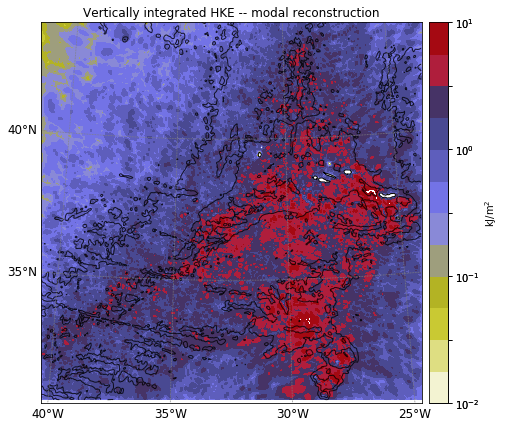

In [25]:
### plotting: reconstructed vertically-integrated field   
toplot = data

fig = plt.figure(figsize=(8,7))
ax = plt.subplot(111)
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx,yy,topo,zlevs,colors=topocol,linewidths=1,alpha=0.8)

# blurring
if doblur:
    dx = (np.diff(xx,axis=1).ravel() + np.diff(yy,axis=0).ravel()).mean()*1e-3/2.
    toplot = ndimage.gaussian_filter(toplot, sigma=Lblu/dx)

if mascale == 'linear':
    hpc = bm.contourf(xx,yy,toplot,levels,cmap=cmap,extend='max',linestyles=None)
    hcb = bm.colorbar(hpc,extend="max")
    #hcb.set_ticks(np.r_[0,hcb.get_ticks()])
    hcb.formatter.set_powerlimits((-1, 1))
    #hcb.formatter.set_useMathText(True)
    hcb.update_ticks()
elif mascale == 'log':
    hpc = bm.contourf(xx,yy,toplot,levels,cmap=cmap,norm = LogNorm(),linestyles=None)
    hcb = bm.colorbar(hpc)
for item in hpc.collections:
    item.set_rasterized('True')
#hpc = bm.pcolormesh(xx,yy,toplot,cmap=cmap,vmax=vmax)
#hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot.values,mask),levels,cmap=cmap,extend='max',linestyles=None)
hcb = bm.colorbar(hpc,extend="max")
hcb.set_label(r'kJ/m$^2$')
#hcb.set_ticks(np.r_[0,hcb.get_ticks()])
#hcb.formatter.set_powerlimits((-1, 1))
#hcb.formatter.set_useMathText(True)
plt.title(r'Vertically integrated {} -- modal reconstruction'.format(whatfield))

for item in hpc.collections:
    item.set_rasterized('True')
#hcb.ax.tick_params(labelsize=fs)
hcb.update_ticks()


if dosavefig:
    plt.savefig(dirpic+simul+'CHANGE_CE_NOM',magnification='auto',bbox_inches="tight",dpi=150)

In [10]:
# load vertically integrated baroclinic energy

nc = MFDataset(path_data+data_bcl,aggdim="eta_rho")
nt= nc.dimensions['time'].size
xif = nc.variables['xi_rho'][:]
etaf = nc.variables['eta_rho'][:]
lonf = nc.variables['lon_rho'][:]
latf = nc.variables['lat_rho'][:]
if whatfield == "HKE":
    dataf = nc.variables['ekint_lf'][:,:,nt//2]
nc.close()
print("finished loading data")

ncgrd = Dataset(grid_file,'r')
topof = ncgrd.variables['h'][:,xif][etaf,:]
ncgrd.close()
topof.shape


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


finished loading data


(1000, 1000)

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/contour.py:1536: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


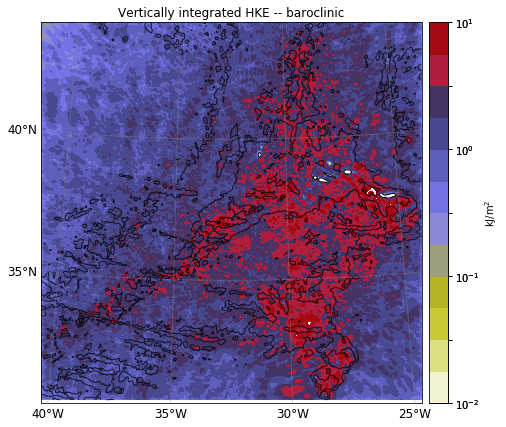

In [15]:
### plotting: reconstructed vertically-integrated field   
toplot = dataf

fig = plt.figure(figsize=(8,7))
ax = plt.subplot(111)
bm = Basemap(projection=proj,resolution=res,lon_0=lonf.mean(),
        lat_0=latf.mean(),width=Lx,height=Ly)
xx, yy = bm(lonf, latf)
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx,yy,topof,zlevs,colors=topocol,linewidths=1,alpha=0.8)

# blurring
if doblur:
    dx = (np.diff(xx,axis=1).ravel() + np.diff(yy,axis=0).ravel()).mean()*1e-3
    toplot = ndimage.gaussian_filter(toplot, sigma=Lblu/dx)

if mascale == 'linear':
    hpc = bm.contourf(xx,yy,toplot,levels,cmap=cmap,extend='max',linestyles=None)
    hcb = bm.colorbar(hpc,extend="max")
    #hcb.set_ticks(np.r_[0,hcb.get_ticks()])
    hcb.formatter.set_powerlimits((-1, 1))
    #hcb.formatter.set_useMathText(True)
    hcb.update_ticks()
elif mascale == 'log':
    hpc = bm.contourf(xx,yy,toplot,levels,cmap=cmap,norm = LogNorm(),linestyles=None)
    hcb = bm.colorbar(hpc)
for item in hpc.collections:
    item.set_rasterized('True')
#hpc = bm.pcolormesh(xx,yy,toplot,cmap=cmap,vmax=vmax)
#hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot.values,mask),levels,cmap=cmap,extend='max',linestyles=None)
hcb = bm.colorbar(hpc,extend="max")
hcb.set_label(r'kJ/m$^2$')
#hcb.set_ticks(np.r_[0,hcb.get_ticks()])
#hcb.formatter.set_powerlimits((-1, 1))
#hcb.formatter.set_useMathText(True)
plt.title(r'Vertically integrated {} -- baroclinic'.format(whatfield))

for item in hpc.collections:
    item.set_rasterized('True')
#hcb.ax.tick_params(labelsize=fs)
hcb.update_ticks()


if dosavefig:
    plt.savefig(dirpic+simul+'CHANGE_CE_NOM',magnification='auto',bbox_inches="tight",dpi=150)


In [34]:
help(itp.RectBivariateSpline)

Help on class RectBivariateSpline in module scipy.interpolate.fitpack2:

class RectBivariateSpline(BivariateSpline)
 |  Bivariate spline approximation over a rectangular mesh.
 |  
 |  Can be used for both smoothing and interpolating data.
 |  
 |  Parameters
 |  ----------
 |  x,y : array_like
 |      1-D arrays of coordinates in strictly ascending order.
 |  z : array_like
 |      2-D array of data with shape (x.size,y.size).
 |  bbox : array_like, optional
 |      Sequence of length 4 specifying the boundary of the rectangular
 |      approximation domain.  By default,
 |      ``bbox=[min(x,tx),max(x,tx), min(y,ty),max(y,ty)]``.
 |  kx, ky : ints, optional
 |      Degrees of the bivariate spline. Default is 3.
 |  s : float, optional
 |      Positive smoothing factor defined for estimation condition:
 |      ``sum((w[i]*(z[i]-s(x[i], y[i])))**2, axis=0) <= s``
 |      Default is ``s=0``, which is for interpolation.
 |  
 |  See Also
 |  --------
 |  SmoothBivariateSpline : a smoothi

### Barotropic -> baroclinic conversion term

In [134]:
wondir = os.getenv('HOME')+"/working_on/"
t1, t2 = 900, 1020
app = "-b"

path_nrjbtr = path_data+"DIAG/NRJ_fluxes/{}_btrnrj.?.nc".format(simul)
path_nrjmod = path_data+"{0}_modemap/{0}_mode_scatdiag{1}.nc".format(simul,app)
path_linbtr = path_data+"Tide_Conv/output_data/cterm_M2_linear_theory_Ny05.nc"
path_linmod = path_data+"Tide_Conv/output_data/ModalConv_LinCalc_lucky_M2_20modes.nc"

typs = ["bcl_num", "mod_num", "bcl_lth", "mod_lth"]
fils = {"bcl_num":path_nrjbtr, "mod_num":path_nrjmod, "bcl_lth":path_linbtr, "mod_lth":path_linmod}
#typs = [k for k in fils.keys()]

nc = MFDataset(path_nrjbtr, aggdim="eta_rho")
print("fields available in",os.path.basename(path_nrjbtr))
print(nc.variables.keys(), "\n")
nc.close()

nc = Dataset(path_nrjmod, "r")
print("fields available in",os.path.basename(path_nrjmod))
print(nc.variables.keys(), "\n")
nc.close()

nc = Dataset(path_linbtr, "r")
print("fields available in",os.path.basename(path_linbtr))
print(nc.variables.keys(), "\n")
nc.close()

nc = Dataset(path_linmod, "r")
print("fields available in",os.path.basename(path_linmod))
print(nc.variables.keys(), "\n")
nc.close()

# load topo and define mask
ncgrd = Dataset(grid_file,'r')
hraw = ncgrd.variables['h'][:]
mask = (hraw>300)
ncgrd.close()

### load subdomains and define useful functions
with open(wondir+"NRJ_flux_diag/subdomains_lucky.json", "r") as fp:
    prov = json.load(fp)
mydoms = OrderedDict()
for key in ["seamounts","ridges","islands"]:
    mydoms[key] = prov[key]
## unfold subdomains
doms, nams = [], []
for key,val in mydoms.items():
    if key == "ridges":
        for ido,dom in enumerate(val):
            doms.append(dom)
            nams.append(key.rstrip("s")+str(ido+1))
    else:
        doms.append(val)
        nams.append(key)
        
# local routines
def coord_to_pix(pos, lon=lon, lat=lat):
    return np.unravel_index(((lon-pos[0])**2+(lat-pos[1])**2).argmin(), lon.shape)[::-1]

def poly_to_mask(poly,shape):
    img = Image.new('1',shape)
    ImageDraw.Draw(img).polygon(poly, outline=1, fill=1)
    return np.array(img)

def polycoord_tomask(coord,lon,lat):
    poly = [coord_to_pix(item,lon,lat) for item in coord]
    return poly_to_mask(poly,lon.shape)

def get_domean(field, dom, lon=lon, lat=lat, masksup=(hraw>100)):
    mask = polycoord_tomask(dom, lon, lat)
    if masksup is not None: mask *= masksup
    return np.nanmean(field[...,mask], axis=(-1))

fields available in luckym2_btrnrj.?.nc
odict_keys(['time', 'scrum_time', 'xi_rho', 'eta_rho', 'lon_rho', 'lat_rho', 'pu_bt', 'pv_bt', 'Ct', 'ek_bt', 'ep_bt', 'pubt_lf', 'pvbt_lf', 'Ct_lf', 'ekbt_lf', 'epbt_lf', 'pubt_avg', 'pvbt_avg', 'Ct_avg', 'ekbt_avg', 'epbt_avg']) 

fields available in luckym2_mode_scatdiag-b.nc
odict_keys(['xi_rho', 'eta_rho', 'lon_rho', 'lat_rho', 'KE', 'APE', 'TotE', 'divf', 'Cmn', 'Cbcl', 'DissTot', 'DissRes']) 

fields available in cterm_M2_linear_theory_Ny05.nc
odict_keys(['lon', 'lat', 'h_raw', 'h', 'Ct']) 

fields available in ModalConv_LinCalc_lucky_M2_20modes.nc
odict_keys(['mode', 'lon', 'lat', 'mask', 'Ctn']) 



In [135]:
### load data in dictionnaries
xi, eta = {}, {}
lon, lat = {}, {}
ct, ctn = {}, {}

typ = typs[0]
fil = fils[typ]
nc = MFDataset(fil, aggdim="eta_rho")
tt_bcl_num = nc.variables['time'][:]
indt, = np.where((tt_bcl_num>=t1) & (tt_bcl_num<=t2))
ct[typ] = nc.variables['Ct_lf'][:][...,indt].mean(axis=-1)
xi[typ], eta[typ] = nc.variables['xi_rho'][:], nc.variables['eta_rho'][:]
lon[typ], lat[typ] = nc.variables['lon_rho'][:], nc.variables['lat_rho'][:]
nc.close()
print("loaded {} conversion from simulation".format(typ))

typ = typs[1]
fil = fils[typ]
nc = Dataset(fil, aggdim="eta_rho")
ctn[typ] = nc.variables['Cmn'][0,1:,...]
xi[typ], eta[typ] = nc.variables['xi_rho'][:], nc.variables['eta_rho'][:]
lon[typ], lat[typ] = nc.variables['lon_rho'][:], nc.variables['lat_rho'][:]
nc.close()
ct[typ] = ctn[typ].sum(axis=0)
print("loaded {} conversion from simulation".format(typ))

typ = typs[2]
fil = fils[typ]
nc = Dataset(fil, aggdim="eta_rho")
ct[typ] = nc.variables['Ct'][:]
lon[typ], lat[typ] = nc.variables['lon'][:], nc.variables['lat'][:]
if "xi_rho" not in nc.variables:
    ny, nx = nc.variables['lon'].shape
    xi[typ], eta[typ] = np.arange(nx), np.arange(ny)
else:
    xi[typ], eta[typ] = nc.variables['xi_rho'][:], nc.variables['eta_rho'][:]
nc.close()
print("loaded {} conversion from simulation".format(typ))

typ = typs[3]
fil = fils[typ]
nc = Dataset(fil, aggdim="eta_rho")
ctn[typ] = nc.variables['Ctn'][:]
lon[typ], lat[typ] = nc.variables['lon'][:], nc.variables['lat'][:]
if "xi_rho" not in nc.variables:
    ny, nx = nc.variables['lon'].shape
    xi[typ], eta[typ] = np.arange(nx), np.arange(ny)
else:
    xi[typ], eta[typ] = nc.variables['xi_rho'][:], nc.variables['eta_rho'][:]
nc.close()
ct[typ] = ctn[typ].sum(axis=0)

print("loaded {} conversion from simulation".format(typ))


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


loaded bcl_num conversion from simulation
loaded mod_num conversion from simulation


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


loaded bcl_lth conversion from simulation
loaded mod_lth conversion from simulation


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


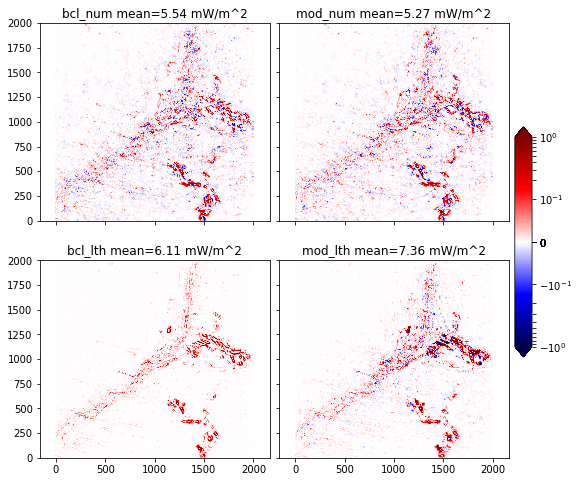

In [136]:
# first: plot all fields in separate panels
cmap = "seismic"
vamp = 1
norm = mpl.colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
    
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8))
for ax, typ in zip(axs.ravel(), typs):
    hpc = ax.pcolormesh(xi[typ], eta[typ], ct[typ], norm=norm, cmap=cmap)
    ax.set_title(typ+" mean={:.2f} mW/m^2".format(np.nanmean(ct[typ][mask[eta[typ],:][:,xi[typ]]])*1e3))

for ax in axs.ravel():
    ax.set_aspect("equal")
    
fig.subplots_adjust(right=0.94, wspace=.04)
cbar_ax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
hcb = fig.colorbar(hpc, cax=cbar_ax, extend="both")

In [137]:
### means of everything (full and subdomain)
ctmoy, ctnoy = {}, {}

for typ in typs:
    domean = lambda x, y: get_domean(x, y, lon[typ], lat[typ], masksup=mask[eta[typ],:][:,xi[typ]])
    ctmoy[typ] = {nam:domean(ct[typ], dom) for nam,dom in zip(nams,doms)}
    ctmoy[typ]["full"] = np.nanmean(ct[typ][mask[eta[typ],:][:,xi[typ]]])
    if "mod" in typ:
        ctnoy[typ] = {nam:domean(ctn[typ], dom) for nam,dom in zip(nams,doms)}
        ctnoy[typ]["full"] = np.nanmean(ctn[typ][:,mask[eta[typ],:][:,xi[typ]]], axis=-1)
 

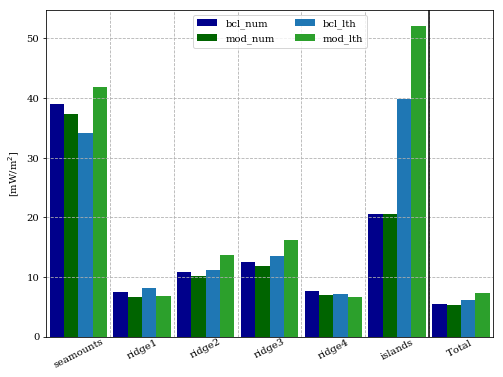

In [188]:
## bar plot of ctmoy
ind = np.arange(len(nams)+1)
width = .9
cols = {"bcl_num":"darkblue", "bcl_lth":"tab:blue", "mod_lth":"tab:green", "mod_num":"darkgreen"}

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for ina,nam in enumerate(nams):
    for ifi,fie in enumerate(typs):
        lab = fie if ina==0 else None
        ax.bar(ind[ina]-width/2+width*(ifi+.5)/len(typs), ctmoy[fie][nam]*1e3, width/len(typs), 
               color=cols[fie], label=lab)
        #print(fie, res[nam][fie])
#print("full")
for ifi,fie in enumerate(typs):
    ax.bar(ind[-1]-width/2+width*(ifi+.5)/len(typs), ctmoy[fie]["full"]*1e3, width/len(typs), 
        color=cols[fie])
    #print(fie, eval(fie))

ax.set_xlim([-.5,len(nams)+.5])
ax.axvline(len(nams)-.5, color="k")
ax.set_xticks(ind)
ax.set_xticklabels(nams+['Total '], rotation=27, y=.02, ha="center")
ax.set_xticks(ind+.5,minor=True)
ax.grid(which="major", axis="x", linestyle="none")
ax.grid(which="minor", axis="x", linestyle="--")
ax.tick_params(bottom=False, which="both")
ax.grid(axis="y", linestyle="--")
ax.set_ylabel(r'[mW/m$^2$]')
fig.legend(ncol=2, bbox_to_anchor=(.73,1), bbox_transform=ax.transAxes)
#plt.title("NRJ balance per subdomain")

if True:
    fig.savefig("pictures/comp_linFa14_model/{0}_Ct_ModBcBt_NumLinTh_comp.pdf".format(simul), 
                magnification="auto", bbox_inches="tight")

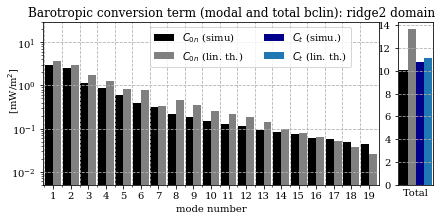

In [219]:
### modal: every mode number + total, per (sub)domain
# that's currently the version in the paper (november 11th)

nam = "ridge2"
cols = cols
cols["mod_num"] = "black"
cols["mod_lth"] = "grey"
nmod = 20
limy = (5e-3, 30)
inds = np.arange(1,nmod)
labs = {"bcl_num":r"$C_t$ (simu.)", "bcl_lth":r"$C_t$ (lin. th.)", 
        "mod_num":r"$C_{0n}$ (simu)", "mod_lth":r"$C_{0n}$ (lin. th.)"}

fig, axs = plt.subplots(1, 2, figsize=(7,3), gridspec_kw = {'width_ratios':[nmod-1, 2]})
ax = axs[0]
for ifi,fie in enumerate(ctnoy.keys()):
    ax.bar(inds-width/2+width*(ifi+.5)/len(ctnoy), ctnoy[fie][nam]*1e3, width/len(ctnoy), 
            color=cols[fie], log=True)
        #print(fie, res[nam][fie])

bx = axs[1]
for ifi,fie in enumerate(ctnoy.keys()):
    lab = labs[fie]
    bx.bar(-width/2+width*(ifi+.5)/len(typs), ctnoy[fie][nam].sum()*1e3, width/len(typs), 
            color=cols[fie], label=lab)
for ifi,fie in enumerate([item for item in prov if item not in ctnoy.keys()]):
    lab = labs[fie]
    ifi += len(ctnoy)
    bx.bar(-width/2+width*(ifi+.5)/len(typs), ctmoy[fie][nam]*1e3, width/len(typs), 
            color=cols[fie], label=lab)

ax.set_xlim([.4,nmod-.4])
ax.set_xticks(inds)
ax.set_ylim(limy)
#ax.set_xticklabels(nams+['Total '], rotation=27, y=.02, ha="center")
ax.set_xticks(inds-.5,minor=True)
ax.grid(which="major", axis="x", linestyle="none")
ax.grid(which="minor", axis="x", linestyle="--")
#    ax.tick_params(bottom=False, which="both")
ax.grid(axis="y", linestyle="--")
ax.set_ylabel(r'  [mW/m$^2$]', va="top", ha="left", x=0, y=4e-1)
ax.set_xlabel('mode number')
bx.set_xticks([])
bx.set_xlabel('Total')
bx.grid(axis="y", linestyle="--")

fig.subplots_adjust(wspace=.1)
fig.legend(ncol=2, bbox_to_anchor=(.93,1), bbox_transform=ax.transAxes)
fig.suptitle("Barotropic conversion term (modal and total bclin): {} domain".format(nam), y=.95, va="top")

if True:
    fig.savefig('pictures/paper/{0}_ModalConv_{1}.pdf'.format(simul,nam), magnification="auto", bbox_inches="tight")

In [207]:
ax.get_ylim()

(0.002347227963888979, 35.625294892069284)